## __Cats and Dogs Classification__

The Asirra (animal species image recognition for restricting access) dataset was introduced in 2013 for a machine learning competition. The dataset includes 25,000 images with equal numbers of labels for cats and dogs.

Dataset: [Cats and Dogs dataset](https://www.kaggle.com/c/dogs-vs-cats/data)

### Prepare dataset for training model:

### Given data is in Zip format. So first we have to unzip the files.

In [1]:
### Unzipping Dataset
import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

### Import the libraries:

In [2]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline


### Importing the Dataset into Train and Test

In [3]:
DIR_TRAIN = "/kaggle/working/train/"
DIR_TEST = "/kaggle/working/test1"

### Checking Data Format

In [4]:
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['dog.9004.jpg', 'cat.687.jpg', 'cat.3987.jpg', 'cat.5803.jpg', 'cat.12047.jpg']
['1476.jpg', '10150.jpg', '6200.jpg', '11685.jpg', '11226.jpg']


### Class Distribution of Dog and Cat

In [5]:
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

print("No of Dogs Images: ",len(dogs_list))
print("No of Cats Images: ",len(cats_list))

class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

No of Dogs Images:  12500
No of Cats Images:  12500


### Transforms for image - ToTensor and other augmentations

In [6]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

### Dataset Class - for retriving images and labels

In [7]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)
    

### Splitting data into training set and vali sets

In [8]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

### Prepare dataset for training model:

In [9]:
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())
test_dataset = CatDogDataset(test_imgs, class_to_int, mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)


### Visualize some Random Images from Training set

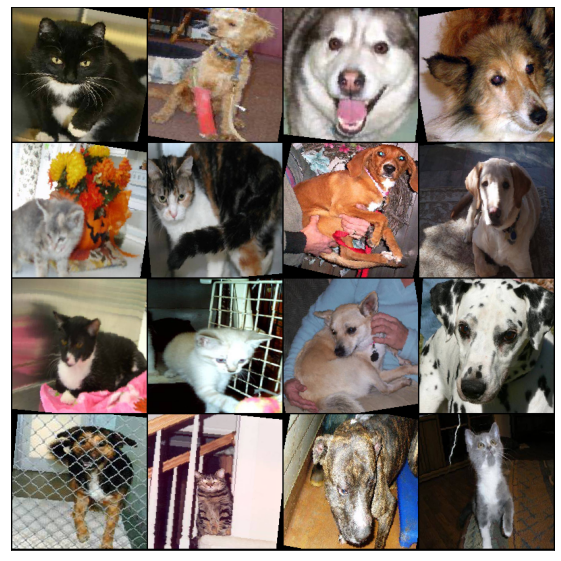

In [10]:
for images, labels in train_data_loader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break
    

### Check for GPU availability

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Define a function to calculate accuracy

In [12]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)
    
    

### Define a Function to train over Epoch

In [13]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
        

### Define a Function over Validation - One Epoch

In [14]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc
        

### RESNET50 Pretrained Model

Resnet models were proposed in “Deep Residual Learning for Image Recognition”. Here we have the 5 versions of resnet models, which contains 5, 34, 50, 101, 152 layers respectively. 
We are using ResNet 50 model.

(Check Reference: 1)

In [15]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


### Defining model parameters Like Optimizer, Learning rate, Loss Function, epochs:

(Check Reference: 2)

In [18]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

### Train Training and Validation sets
(Check Referance:3)

In [19]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    


Training
Epoch 1
Loss : 0.0871
Acc : 96.7782
Time : 146.6975

Validating
Epoch 1
Loss : 0.062
Acc : 97.6982
Time : 38.9252

Training
Epoch 2
Loss : 0.0606
Acc : 97.6483
Time : 147.6021

Validating
Epoch 2
Loss : 0.0485
Acc : 98.296
Time : 38.0522

Training
Epoch 3
Loss : 0.0544
Acc : 98.0688
Time : 146.6145

Validating
Epoch 3
Loss : 0.0556
Acc : 98.0019
Time : 38.1285

Training
Epoch 4
Loss : 0.0454
Acc : 98.2128
Time : 146.1746

Validating
Epoch 4
Loss : 0.0479
Acc : 98.0019
Time : 38.3517

Training
Epoch 5
Loss : 0.0432
Acc : 98.3095
Time : 145.9522

Validating
Epoch 5
Loss : 0.0502
Acc : 98.1298
Time : 38.8418

Training
Epoch 6
Loss : 0.04
Acc : 98.4802
Time : 145.6056

Validating
Epoch 6
Loss : 0.046
Acc : 98.1937
Time : 38.9692

Training
Epoch 7
Loss : 0.0376
Acc : 98.5122
Time : 145.2782

Validating
Epoch 7
Loss : 0.0543
Acc : 98.2417
Time : 39.3003

Training
Epoch 8
Loss : 0.0339
Acc : 98.6775
Time : 144.569

Validating
Epoch 8
Loss : 0.0548
Acc : 97.9923
Time : 39.7332

Train

### Lets Plot The Accuracies and Losses

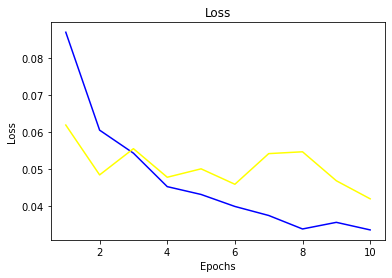

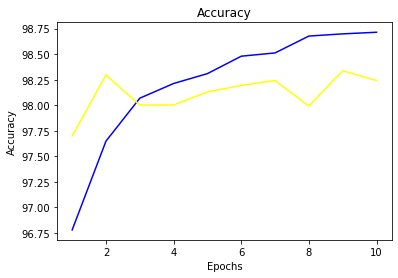

In [21]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [22]:
!pip install jovian --upgrade --quiet

In [23]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='Dog-Vs-Cat-Project-Zero-to-Gans')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/swapnilbhange/Dog-Vs-Cat-Project-Zero-to-Gans


<IPython.core.display.Javascript object>

References: 
1. [RESNET50](https://pytorch.org/hub/pytorch_vision_resnet/)

2.[Optimizer, Learinig rate, Loss Function and Epoch](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

3.[Training and Validation dataset](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets)

4. [Pytorch Documentation](http://pytorch.org)